In [1]:
#! pip install mlconfound

In [50]:
#! pip install graphviz

In [51]:
import os, sys
from glob import glob
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=False)
import h5py
import json
from tqdm.notebook import tqdm

import dataframe_image as dfi
from mlconfound.stats import partial_confound_test, full_confound_test

from mlconfound.simulate import simulate_y_c_yhat
from mlconfound.plot import plot_null_dist, plot_graph

import pandas as pd
import seaborn as sns

In [52]:
def test_runner(model_path, best_run, confound, confound_path, binned=False, task_type=None):
    df = pd.read_csv(model_path)
    val_lbls = df['val_lbls'][best_run]
    val_preds = df['val_preds'][best_run]
    val_ids = df['val_ids'][best_run]

    if task_type =='binary':
        val_preds_binary = df['val_preds'][best_run]

    val_lbls = val_lbls[1:-1]
    val_preds = val_preds[1:-1]
    val_ids = val_ids[1:-1]

    if task_type =='binary':
        val_preds_binary = val_preds_binary[1:-1]

    # Split string by commas
    val_lbls = val_lbls.split(", ")
    val_preds = val_preds.split(", ")
    val_ids = val_ids.split(", ")

    if task_type =='binary':
        val_preds_binary = val_preds_binary.split(", ")

     # Convert all values to float
    val_lbls = np.array([float(x) for x in val_lbls])
    val_preds = np.array([float(x) for x in val_preds])
    val_ids = [float(x) for x in val_ids]

    if task_type =='binary':
        val_preds_binary =[float(x) for x in val_preds]
        val_preds_binary=[1.0 if x > 0.0 else 0.0 for x in val_preds_binary]

    #same process with holdout
    if holdout == True:
        hold_lbls = df['hold_lbls'][best_run]
        hold_preds = df['hold_preds'][best_run]
        hold_ids = df['hold_ids'][best_run]

        if task_type =='binary':
            hold_preds_binary = df['hold_preds'][best_run]

        hold_lbls = hold_lbls[1:-1]
        hold_preds = hold_preds[1:-1]
        hold_ids = hold_ids[1:-1]

        if task_type =='binary':
            hold_preds_binary = hold_preds_binary[1:-1]

        hold_lbls = hold_lbls.split(", ")
        hold_preds = hold_preds.split(", ")
        hold_ids = hold_ids.split(", ")

        if task_type =='binary':
            hold_preds_binary = hold_preds_binary.split(", ")

        hold_lbls = np.array([float(x) for x in hold_lbls])
        hold_preds = np.array([float(x) for x in hold_preds])
        hold_ids = [float(x) for x in hold_ids]

        if task_type =='binary':
            hold_preds_binary = [float(x) for x in hold_preds_binary]
            hold_preds_binary=[1.0 if x > 0.0 else 0.0 for x in hold_preds_binary]
        
    #We get the subject id_s for the confounds and set them as index equally as the way ids are in the .csv
    confound_df = pd.read_csv(confound_path)
    confound_df['subjectID_i'] = confound_df['subjectID'].apply(lambda x: str(x) + '.0')
    confound_df['subjectID_i'] = confound_df['subjectID_i'].apply(lambda x:float(x))
    confound_df.set_index('subjectID_i', inplace=True)

    #Create the dataframe with the info to run the test
    if task_type =='binary':
        df_val=pd.DataFrame({'val_lbls':val_lbls,
                            'val_preds':val_preds_binary}, index=val_ids)

    else:
        df_val=pd.DataFrame({'val_lbls':val_lbls,
                              'val_preds':val_preds,}, index=val_ids)

    if holdout==True:
        if task_type =='binary':
            df_hold=pd.DataFrame({'hold_lbls':hold_lbls,
                                'hold_preds':hold_preds_binary}, index=hold_ids)

        else:
            df_hold=pd.DataFrame({'hold_lbls':hold_lbls,
                                  'hold_preds':hold_preds,}, index=hold_ids)

    y_c=[]
    y_yhat=[]
    yhat_c=[]
    confounds=[]
    p_values=[]

    if holdout==True:
        y_c_hold=[]
        y_yhat_hold=[]
        yhat_c_hold=[]
        confounds_hold=[]
        p_values_hold=[]

    confound_cols=confound
    #confound_cols=confound_cols[1:]
    for c in confound_cols:
        df_val[c]=confound_df[c]
        if binned ==True:
            df_val['c']=confound_df[f'{c} binned']
        else:
            df_val['c']=confound_df[c]
        print(f"running partial test for confound {c} validation set...")
        partialtest=partial_confound_test(df_val['val_lbls'], df_val['val_preds'], df_val[c], num_perms=1000,
                      random_state=46, n_jobs=-1)

        #print(partialtest)
        #print(c,partialtest.r2_y_c,partialtest.r2_y_yhat,partialtest.r2_yhat_c,partialtest.p)
        confounds.append(c)
        y_c.append(partialtest.r2_y_c)
        y_yhat.append(partialtest.r2_y_yhat)
        yhat_c.append(partialtest.r2_yhat_c)
        p_values.append(partialtest.p)


        if holdout==True:
            print(f"running partial test for confound {c} holdout set ...")
            df_hold[c]=confound_df[c]
            if binned ==True:
                df_hold['c']=confound_df[f'{c} binned']
            else:
                df_hold['c']=confound_df[c]
            partialtest_hold=partial_confound_test(df_hold['hold_lbls'], df_hold['hold_preds'], df_hold[c], num_perms=1000,
                      random_state=46, n_jobs=-1)

            y_c_hold.append(partialtest_hold.r2_y_c)
            y_yhat_hold.append(partialtest_hold.r2_y_yhat)
            yhat_c_hold.append(partialtest_hold.r2_yhat_c)
            p_values_hold.append(partialtest_hold.p)


    print('Creating final DataFrame...')
    df_results=pd.DataFrame({'Potential Confounder':confounds,
                            'R2_y_c':y_c,
                            'R2_y_yhat':y_yhat,
                            'R2_yhat_c':yhat_c,
                             'p_val':p_values},index=confounds)
    #we add holdout results
    if holdout==True:
            df_results['R2_y_c_hold'] = y_c_hold
            df_results['R2_y_yhat_hold'] = y_yhat_hold
            df_results['R2_yhat_c_hold'] = yhat_c_hold
            df_results['p_values_hold'] = p_values_hold
    
    return df_results, df_hold, partialtest_hold



## Biased Training
#### Sex
#### High Alcohol Usage
#### TM Test
#### TM Test binary

## Sex

In [89]:
model_path='/ritter/share/projects/gonzalo/thesis/raw_and_reweighing/CNNpipeline/results/final-results-biased/confounds_ukbb_sex-final-confounds_tasks_8364k_train/20230127-1613/run.csv'

In [90]:
holdout=True
task_type=None
best_run= 2
confound =['Total brain volume']
confound_path='/ritter/share/projects/gonzalo/thesis/raw_and_reweighing/CNNpipeline/11824k_fullcohort_with_holdout_numerical_labels.csv'
binned = True
softmax_int= True
#get info from the .csv of the run
df_results, df_hold, partialtest_hold = test_runner(model_path, best_run, confound, confound_path, binned)

running partial test for confound Total brain volume validation set...


Permuting: 100%|███████████████████████████| 1000/1000 [00:02<00:00, 432.05it/s]


running partial test for confound Total brain volume holdout set ...


Permuting: 100%|███████████████████████████| 1000/1000 [00:02<00:00, 345.11it/s]


Creating final DataFrame...


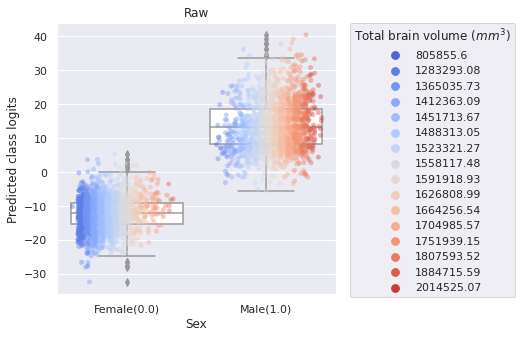

In [91]:
df_hold.loc[df_hold['hold_lbls']==0.0, 'hold_lbls'] = 'Female(0.0)'
df_hold.loc[df_hold['hold_lbls']==1.0, 'hold_lbls'] = 'Male(1.0)'
plt.figure(figsize=(5,5))
sns.stripplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], hue=round(df_hold.c,2),
palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], color=(1,1,1,1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Total brain volume ($mm^3$)')
plt.xlabel('Sex')
plt.ylabel('Predicted class logits')
#plt.ylim([0,1])
plt.title('Raw')
plt.savefig("sex-totalbrainvolume-biased-raw.jpg", bbox_inches='tight')

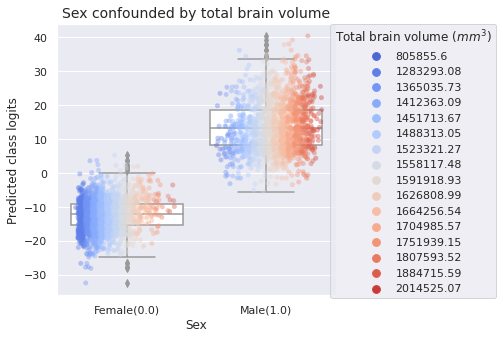

In [92]:
df_hold.loc[df_hold['hold_lbls']==0.0, 'hold_lbls'] = 'Female(0.0)'
df_hold.loc[df_hold['hold_lbls']==1.0, 'hold_lbls'] = 'Male(1.0)'
plt.figure(figsize=(5,5))
sns.stripplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], hue=round(df_hold.c,2),
palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], color=(1,1,1,1))
plt.legend(bbox_to_anchor=(0.98, 1), loc=2, borderaxespad=0., title='Total brain volume ($mm^3$)')
plt.xlabel('Sex')
plt.ylabel('Predicted class logits')
plt.title('Sex confounded by total brain volume', fontsize=14)
plt.savefig("sex-totalbrainvolume-biased-raw-alone.jpg", bbox_inches='tight')

In [69]:
#plot_graph(partialtest_hold, y_name='Sex', yhat_name='prediction', c_name='Total brain volume', outfile_base='example')

## High Alcohol Usage

In [60]:
model_path='/ritter/share/projects/gonzalo/thesis/raw_and_reweighing/CNNpipeline/results/final-results-biased/confounds_ukbb_alc-classif-binary_-t1mniz2-l-highalcl0u2-bingeauditl1u3-alcfreq-c-sex-age-n14617/20230128-1219/run.csv'

In [62]:
holdout=True
task_type=None
best_run= 2
confound =['Sex']
confound_path='/ritter/share/projects/gonzalo/thesis/raw_and_reweighing/CNNpipeline/18077k_fullcohort_with_alcohol_numerical_labels.csv'
binned = False
#get info from the .csv of the run
df_results, df_hold, partialtest_hold = test_runner(model_path, best_run, confound, confound_path, binned)

running partial test for confound Sex validation set...


Permuting: 100%|███████████████████████████| 1000/1000 [00:04<00:00, 238.67it/s]


running partial test for confound Sex holdout set ...


Permuting: 100%|███████████████████████████| 1000/1000 [00:02<00:00, 359.22it/s]

Creating final DataFrame...


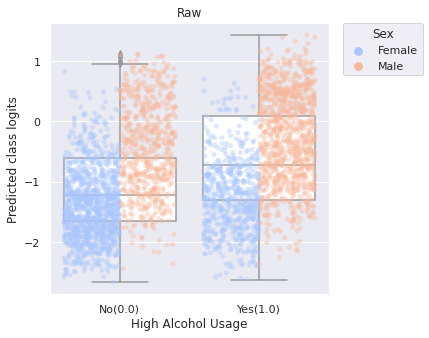

In [63]:
df_hold.loc[df_hold['hold_lbls']==0.0, 'hold_lbls'] = 'No(0.0)'
df_hold.loc[df_hold['hold_lbls']==1.0, 'hold_lbls'] = 'Yes(1.0)'
df_hold.loc[df_hold['c']==0.0, 'Sex'] = 'Female'
df_hold.loc[df_hold['c']==1.0, 'Sex'] = 'Male'
plt.figure(figsize=(5,5))
sns.stripplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], hue=df_hold.Sex,
palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], color=(1,1,1,1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Sex')
plt.xlabel('High Alcohol Usage')
plt.ylabel('Predicted class logits')
plt.title('Raw')
plt.savefig("highalc-sex-biased_raw.jpg", bbox_inches='tight')

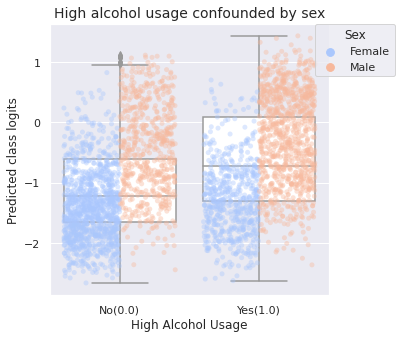

In [64]:
df_hold.loc[df_hold['hold_lbls']==0.0, 'hold_lbls'] = 'No(0.0)'
df_hold.loc[df_hold['hold_lbls']==1.0, 'hold_lbls'] = 'Yes(1.0)'
df_hold.loc[df_hold['c']==0.0, 'Sex'] = 'Female'
df_hold.loc[df_hold['c']==1.0, 'Sex'] = 'Male'
plt.figure(figsize=(5,5))
sns.stripplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], hue=df_hold.Sex,
palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], color=(1,1,1,1))
plt.legend(bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0., title='Sex')
plt.xlabel('High Alcohol Usage')
plt.ylabel('Predicted class logits')
plt.title('High alcohol usage confounded by sex', fontsize=14)
plt.savefig("highalc-sex-biased_raw_alone.jpg", bbox_inches='tight')

In [15]:
#plot_graph(partialtest_hold, y_name='High Alcohol Usage', yhat_name='prediction', c_name='Sex', outfile_base='example')

### Trail Making Test

In [16]:
model_path='/ritter/share/projects/gonzalo/thesis/ML_for_alcohol_misuse/CNNpipeline/results/final-results-biased/confounds_ukbb_trailmaking-final-confounds_tasks_8364k_train/20230127-1614/run.csv'

In [17]:
holdout=True
task_type=None
best_run= 1
confound =['Age']
confound_path='/ritter/share/projects/gonzalo/thesis/ML_for_alcohol_misuse/CNNpipeline/11824k_fullcohort_with_holdout_numerical_labels.csv'
binned = True
#get info from the .csv of the run
df_results, df_hold, partial_test = test_runner(model_path, best_run, confound, confound_path, binned)

running partial test for confound Age validation set...


Permuting: 100%|███████████████████████████| 1000/1000 [00:04<00:00, 231.76it/s]


running partial test for confound Age holdout set ...


Permuting: 100%|███████████████████████████| 1000/1000 [00:05<00:00, 196.89it/s]

Creating final DataFrame...


In [18]:
def denormalize(df, column, max_value_column, min_value_column):
    max_value = df[max_value_column].max()
    min_value = df[min_value_column].min()
    df[column] = df[column] * (max_value - min_value) + min_value
    return df
    #y_data = y_data * (original_max - original_min) + original_min
df_hold = denormalize(df_hold, 'hold_preds', 'hold_lbls', 'hold_lbls')

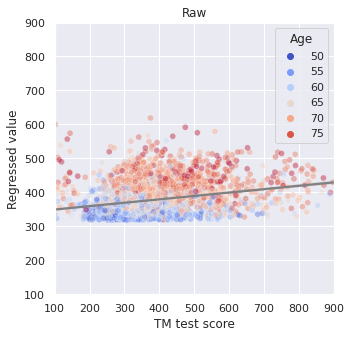

In [19]:
plt.figure(figsize=(5,5))
sns.regplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], scatter=False, color='gray')
sns.scatterplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], hue=df_hold.c, palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.legend(title='Age')
plt.ylim(100,900)
plt.xlim(100,900)
plt.xlabel('TM test score')
plt.ylabel('Regressed value')
plt.title('Raw')
plt.savefig("TMTest-raw.jpg", bbox_inches='tight')

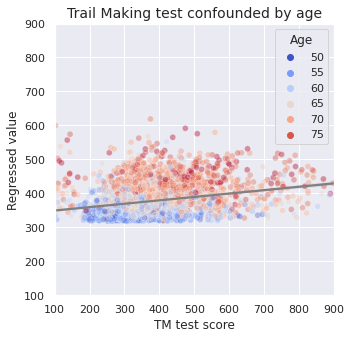

In [20]:
plt.figure(figsize=(5,5))
sns.regplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], scatter=False, color='gray')
sns.scatterplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], hue=df_hold.c, palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.legend(title='Age')
plt.ylim(100,900)
plt.xlim(100,900)
plt.xlabel('TM test score')
plt.ylabel('Regressed value')
plt.title('Trail Making test confounded by age', fontsize=14)
plt.savefig("TMTest-raw-alone.jpg", bbox_inches='tight')

In [30]:
#plot_graph(partial_test, y_name='TM Test', yhat_name='prediction', c_name='Age', outfile_base='example')

In [ ]:
#plot_graph(partialtest_hold, y_name='High Alcohol Usage', yhat_name='prediction', c_name='Sex', outfile_base='example')

## Reweighing Results
#### -Sex 
#### -High alcohol
#### - Trail making Test

### Sex

In [65]:
model_path='/ritter/share/projects/gonzalo/thesis/raw_and_reweighing/CNNpipeline/results/Reweighing-Sex-brain-volume-confounds_tasks_8364k_train/20230201-1051/run.csv'

In [66]:
holdout=True
task_type=None
best_run= 2
confound =['Total brain volume']
confound_path='/ritter/share/projects/gonzalo/thesis/raw_and_reweighing/CNNpipeline/11824k_fullcohort_with_holdout_numerical_labels.csv'
binned = True 
df_results, df_hold, partialtest_hold = test_runner(model_path, best_run, confound, confound_path, binned)


running partial test for confound Total brain volume validation set...


Permuting: 100%|███████████████████████████| 1000/1000 [00:02<00:00, 454.92it/s]


running partial test for confound Total brain volume holdout set ...


Permuting: 100%|███████████████████████████| 1000/1000 [00:02<00:00, 365.01it/s]

Creating final DataFrame...


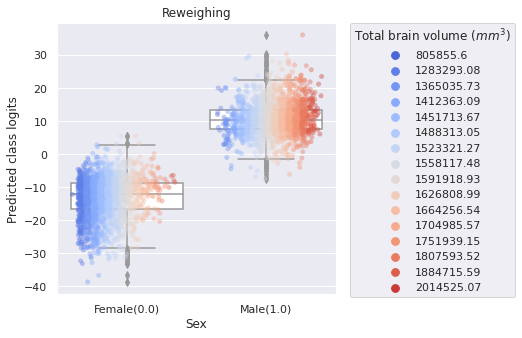

In [67]:
df_hold.loc[df_hold['hold_lbls']==0.0, 'hold_lbls'] = 'Female(0.0)'
df_hold.loc[df_hold['hold_lbls']==1.0, 'hold_lbls'] = 'Male(1.0)'
plt.figure(figsize=(5,5))
sns.stripplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], hue=round(df_hold.c,2),
palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], color=(1,1,1,1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Total brain volume ($mm^3$)')
plt.xlabel('Sex')
plt.ylabel('Predicted class logits')
plt.title('Reweighing')
plt.savefig("sex-totalbrainvolume-biased-reweighing.jpg", bbox_inches='tight')

In [11]:
plot_graph(partialtest_hold, y_name='Sex', yhat_name='prediction', c_name='Total brain volume', outfile_base='example')

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

## High Alcohol Usage

In [68]:
model_path = '/ritter/share/projects/gonzalo/thesis/raw_and_reweighing/CNNpipeline/results/Reweighing-Alc-sex-bis-t1mniz2-l-highalcl0u2-bingeauditl1u3-alcfreq-c-sex-age-n14617/20230130-1232/run.csv'

In [69]:
holdout=True
task_type=None
best_run= 2
confound =['Sex']
confound_path='/ritter/share/projects/gonzalo/thesis/raw_and_reweighing/CNNpipeline/18077k_fullcohort_with_alcohol_numerical_labels.csv'
binned = False 
df_results, df_hold, partialtest_hold = test_runner(model_path, best_run, confound, confound_path, binned)

running partial test for confound Sex validation set...


Permuting: 100%|███████████████████████████| 1000/1000 [00:04<00:00, 215.73it/s]


running partial test for confound Sex holdout set ...


Permuting: 100%|███████████████████████████| 1000/1000 [00:02<00:00, 381.93it/s]

Creating final DataFrame...


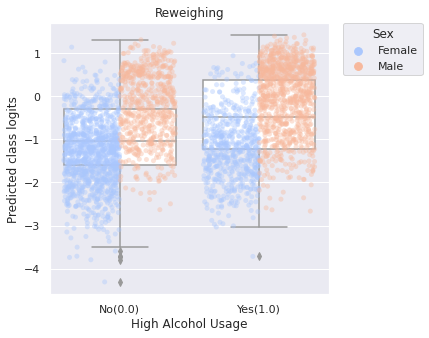

In [70]:
df_hold.loc[df_hold['hold_lbls']==0.0, 'hold_lbls'] = 'No(0.0)'
df_hold.loc[df_hold['hold_lbls']==1.0, 'hold_lbls'] = 'Yes(1.0)'
df_hold.loc[df_hold['c']==0.0, 'Sex'] = 'Female'
df_hold.loc[df_hold['c']==1.0, 'Sex'] = 'Male'
plt.figure(figsize=(5,5))
sns.stripplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], hue=df_hold.Sex,
palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], color=(1,1,1,1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Sex')
plt.xlabel('High Alcohol Usage')
plt.ylabel('Predicted class logits')
plt.title('Reweighing')
plt.savefig("highalc-sex-biased_reweighing.jpg", bbox_inches='tight')

In [26]:
#plot_graph(partialtest_hold, y_name='High Alcohol Usage', yhat_name='prediction', c_name='Sex', outfile_base='example')

### Trail Making Test

In [71]:
model_path='/ritter/share/projects/gonzalo/thesis/raw_and_reweighing/CNNpipeline/results/Reweighing-trailmaking-age-confounds_tasks_8364k_train_bis/20230130-1714/run.csv'

In [72]:
holdout=True
task_type=None
best_run= 2
confound =['Age']
confound_path='/ritter/share/projects/gonzalo/thesis/raw_and_reweighing/CNNpipeline/11824k_fullcohort_with_holdout_numerical_labels.csv'
binned = True
#get info from the .csv of the run
df = pd.read_csv(model_path)
val_lbls = df['val_lbls'][best_run]
val_preds = df['val_preds'][best_run]
val_ids = df['val_ids'][best_run]

if task_type =='binary':
    val_preds_binary = df['val_preds'][best_run]

val_lbls = val_lbls[1:-1]
val_preds = val_preds[1:-1]
val_ids = val_ids[1:-1]

if task_type =='binary':
    val_preds_binary = val_preds_binary[1:-1]
    
# Split string by commas
val_lbls = val_lbls.split(", ")
val_preds = val_preds.split(", ")
val_ids = val_ids.split(", ")

if task_type =='binary':
    val_preds_binary = val_preds_binary.split(", ")

 # Convert all values to float
val_lbls = [float(x) for x in val_lbls]
val_preds = [float(x) for x in val_preds]
val_ids = [float(x) for x in val_ids]

if task_type =='binary':
    val_preds_binary =[float(x) for x in val_preds]
    val_preds_binary=[1.0 if x > 0.0 else 0.0 for x in val_preds_binary]

#same process with holdout
if holdout == True:
    hold_lbls = df['hold_lbls'][best_run]
    hold_preds = df['hold_preds'][best_run]
    hold_ids = df['hold_ids'][best_run]

    if task_type =='binary':
        hold_preds_binary = df['hold_preds'][best_run]

    hold_lbls = hold_lbls[1:-1]
    hold_preds = hold_preds[1:-1]
    hold_ids = hold_ids[1:-1]

    if task_type =='binary':
        hold_preds_binary = hold_preds_binary[1:-1]

    hold_lbls = hold_lbls.split(", ")
    hold_preds = hold_preds.split(", ")
    hold_ids = hold_ids.split(", ")

    if task_type =='binary':
        hold_preds_binary = hold_preds_binary.split(", ")

    hold_lbls = [float(x) for x in hold_lbls]
    hold_preds = [float(x) for x in hold_preds]
    hold_ids = [float(x) for x in hold_ids]

    if task_type =='binary':
        hold_preds_binary = [float(x) for x in hold_preds_binary]
        hold_preds_binary=[1.0 if x > 0.0 else 0.0 for x in hold_preds_binary]

#We get the subject id_s for the confounds and set them as index equally as the way ids are in the .csv
confound_df = pd.read_csv(confound_path)
confound_df['subjectID_i'] = confound_df['subjectID'].apply(lambda x: str(x) + '.0')
confound_df['subjectID_i'] = confound_df['subjectID_i'].apply(lambda x:float(x))
confound_df.set_index('subjectID_i', inplace=True)

#Create the dataframe with the info to run the test
if task_type =='binary':
    df_val=pd.DataFrame({'val_lbls':val_lbls,
                        'val_preds':val_preds_binary}, index=val_ids)

else:
    df_val=pd.DataFrame({'val_lbls':val_lbls,
                          'val_preds':val_preds,}, index=val_ids)
    
if holdout==True:
    if task_type =='binary':
        df_hold=pd.DataFrame({'hold_lbls':hold_lbls,
                            'hold_preds':hold_preds_binary}, index=hold_ids)

    else:
        df_hold=pd.DataFrame({'hold_lbls':hold_lbls,
                              'hold_preds':hold_preds,}, index=hold_ids)

y_c=[]
y_yhat=[]
yhat_c=[]
confounds=[]
p_values=[]

if holdout==True:
    y_c_hold=[]
    y_yhat_hold=[]
    yhat_c_hold=[]
    confounds_hold=[]
    p_values_hold=[]

confound_cols=confound
#confound_cols=confound_cols[1:]
for c in confound_cols:
    df_val[c]=confound_df[c]
    if binned ==True:
        df_val['c']=confound_df[f'{c} binned']
    else:
        df_val['c']=confound_df[c]
    print(f"running partial test for confound {c} validation set...")
    partialtest=partial_confound_test(df_val['val_lbls'], df_val['val_preds'], df_val[c], num_perms=1000,
                  random_state=46, n_jobs=-1)
   
    #print(partialtest)
    #print(c,partialtest.r2_y_c,partialtest.r2_y_yhat,partialtest.r2_yhat_c,partialtest.p)
    confounds.append(c)
    y_c.append(partialtest.r2_y_c)
    y_yhat.append(partialtest.r2_y_yhat)
    yhat_c.append(partialtest.r2_yhat_c)
    p_values.append(partialtest.p)
    

    if holdout==True:
        print(f"running partial test for confound {c} holdout set ...")
        df_hold[c]=confound_df[c]
        if binned ==True:
            df_hold['c']=confound_df[f'{c} binned']
        else:
            df_hold['c']=confound_df[c]
        partialtest_hold=partial_confound_test(df_hold['hold_lbls'], df_hold['hold_preds'], df_hold[c], num_perms=1000,
                  random_state=46, n_jobs=-1)
        
        y_c_hold.append(partialtest_hold.r2_y_c)
        y_yhat_hold.append(partialtest_hold.r2_y_yhat)
        yhat_c_hold.append(partialtest_hold.r2_yhat_c)
        p_values_hold.append(partialtest_hold.p)
        

print('Creating final DataFrame...')
df_results=pd.DataFrame({'Potential Confounder':confounds,
                        'R2_y_c':y_c,
                        'R2_y_yhat':y_yhat,
                        'R2_yhat_c':yhat_c,
                         'p_val':p_values},index=confounds)
#we add holdout results
if holdout==True:
        df_results['R2_y_c_hold'] = y_c_hold
        df_results['R2_y_yhat_hold'] = y_yhat_hold
        df_results['R2_yhat_c_hold'] = yhat_c_hold
        df_results['p_values_hold'] = p_values_hold




running partial test for confound Age validation set...


Permuting: 100%|███████████████████████████| 1000/1000 [00:02<00:00, 471.06it/s]


running partial test for confound Age holdout set ...


Permuting: 100%|███████████████████████████| 1000/1000 [00:02<00:00, 383.93it/s]

Creating final DataFrame...


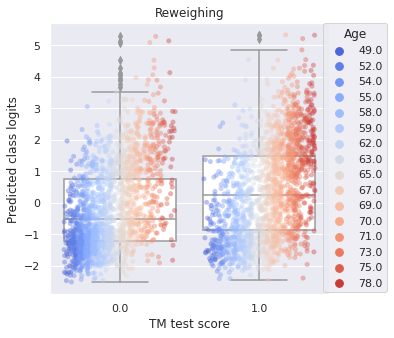

In [73]:
plt.figure(figsize=(5,5))
sns.stripplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], hue=round(df_hold.c,0),
palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], color=(1,1,1,1))
plt.legend(bbox_to_anchor=(0.98, 1), loc=2, borderaxespad=0., title='Age')
plt.xlabel('TM test score')
plt.ylabel('Predicted class logits')
plt.title('Reweighing')
plt.savefig("trailmakingtest-age_reweighing.jpg", bbox_inches='tight')

In [25]:
partialtest_hold

ResultsPartiallyConfounded(r2_y_c=0.11034546310497166, r2_y_yhat=0.03797479359260913, r2_yhat_c=0.28212100689198233, expected_r2_yhat_c=array([0.00152292, 0.00451016, 0.00905351]), p=0.0, p_ci=(0, 0.003682083896865671), null_distribution=None)

In [37]:
#plot_graph(partialtest_hold, y_name='TM Test', yhat_name='prediction', c_name='Age', outfile_base='example')

## PMDN Layer Results
#### -Sex 
#### -High alcohol
#### - Trail making Test

### Sex

In [82]:
model_path='/ritter/share/projects/gonzalo/thesis/PMDN/MLPipeline/CNNPipeline/results/PMDNResNet-sex-confounds_tasks_8364k_train/20230129-0117/run.csv'

In [83]:
holdout=True
task_type=None
best_run= 2
confound =['Total brain volume']
confound_path='/ritter/share/projects/gonzalo/thesis/raw_and_reweighing/CNNpipeline/11824k_fullcohort_with_holdout_numerical_labels.csv'
binned = True
#get info from the .csv of the run
df_results, df_hold, partialtest_hold = test_runner(model_path, best_run, confound, confound_path, binned)

running partial test for confound Total brain volume validation set...


Permuting: 100%|███████████████████████████| 1000/1000 [00:02<00:00, 470.87it/s]


running partial test for confound Total brain volume holdout set ...


Permuting: 100%|███████████████████████████| 1000/1000 [00:02<00:00, 379.10it/s]


Creating final DataFrame...


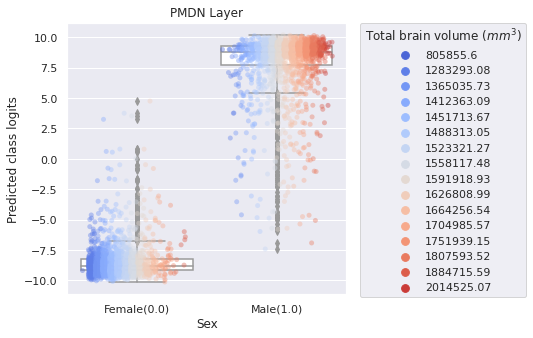

In [84]:
df_hold.loc[df_hold['hold_lbls']==0.0, 'hold_lbls'] = 'Female(0.0)'
df_hold.loc[df_hold['hold_lbls']==1.0, 'hold_lbls'] = 'Male(1.0)'
plt.figure(figsize=(5,5))
sns.stripplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], hue=round(df_hold.c,2),
palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], color=(1,1,1,1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Total brain volume ($mm^3$)')
plt.xlabel('Sex')
plt.ylabel('Predicted class logits')
plt.title('PMDN Layer')
plt.savefig("sex-totalbrainvolume-biased-PMDN.jpg", bbox_inches='tight')

In [85]:
#plot_graph(partialtest_hold, y_name='Sex', yhat_name='prediction', c_name='Total brain volume', outfile_base='example')

### High Alcohol Usage

In [86]:
model_path='/ritter/share/projects/gonzalo/thesis/PMDN/MLPipeline/CNNPipeline/results/PMDNResNet-highalc-t1mniz2-l-highalcl0u2-bingeauditl1u3-alcfreq-c-sex-age-n14617/20230129-1206/run.csv'

In [87]:
holdout=True
task_type=None
best_run= 2
confound =['Sex']
binned = False
confound_path='/ritter/share/projects/gonzalo/thesis/raw_and_reweighing/CNNpipeline/18077k_fullcohort_with_alcohol_numerical_labels.csv'
df_results, df_hold, partialtest_hold = test_runner(model_path, best_run, confound, confound_path, binned)

running partial test for confound Sex validation set...


Permuting: 100%|███████████████████████████| 1000/1000 [00:04<00:00, 241.78it/s]


running partial test for confound Sex holdout set ...


Permuting: 100%|███████████████████████████| 1000/1000 [00:02<00:00, 386.95it/s]

Creating final DataFrame...


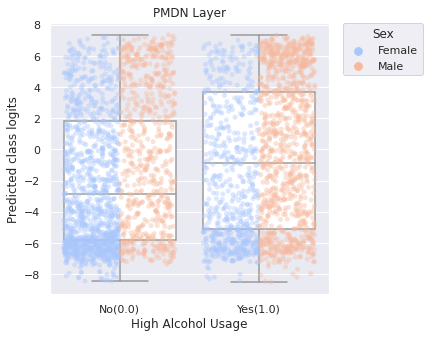

In [88]:
df_hold.loc[df_hold['hold_lbls']==0.0, 'hold_lbls'] = 'No(0.0)'
df_hold.loc[df_hold['hold_lbls']==1.0, 'hold_lbls'] = 'Yes(1.0)'
df_hold.loc[df_hold['c']==0.0, 'Sex'] = 'Female'
df_hold.loc[df_hold['c']==1.0, 'Sex'] = 'Male'
plt.figure(figsize=(5,5))
sns.stripplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], hue=df_hold.Sex,
palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], color=(1,1,1,1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Sex')
plt.xlabel('High Alcohol Usage')
plt.ylabel('Predicted class logits')
plt.title('PMDN Layer')
plt.savefig("highalc-sex-biased_PMDN.jpg", bbox_inches='tight')

In [43]:
#plot_graph(partialtest_hold, y_name='High Alcohol Usage', yhat_name='prediction', c_name='Sex', outfile_base='example')

## Trail Making Test

In [14]:
model_path='/ritter/share/projects/gonzalo/thesis/PMDN/MLPipeline/CNNPipeline/results/PMDNResNet-trailmaking-confounds_tasks_8364k_train/20230130-1144/run.csv'

In [15]:
holdout=True
task_type=None
best_run= 1
confound =['Age']
confound_path='/ritter/share/projects/gonzalo/thesis/ML_for_alcohol_misuse/CNNpipeline/11824k_fullcohort_with_holdout_numerical_labels.csv'
binned = True 
#get info from the .csv of the run
df = pd.read_csv(model_path)
val_lbls = df['val_lbls'][best_run]
val_preds = df['val_preds'][best_run]
val_ids = df['val_ids'][best_run]

if task_type =='binary':
    val_preds_binary = df['val_preds'][best_run]

val_lbls = val_lbls[1:-1]
val_preds = val_preds[1:-1]
val_ids = val_ids[1:-1]

if task_type =='binary':
    val_preds_binary = val_preds_binary[1:-1]
    
# Split string by commas
val_lbls = val_lbls.split(", ")
val_preds = val_preds.split(", ")
val_ids = val_ids.split(", ")

if task_type =='binary':
    val_preds_binary = val_preds_binary.split(", ")

 # Convert all values to float
val_lbls = [float(x) for x in val_lbls]
val_preds = [float(x) for x in val_preds]
val_ids = [float(x) for x in val_ids]

if task_type =='binary':
    val_preds_binary =[float(x) for x in val_preds]
    val_preds_binary=[1.0 if x > 0.0 else 0.0 for x in val_preds_binary]

#same process with holdout
if holdout == True:
    hold_lbls = df['hold_lbls'][best_run]
    hold_preds = df['hold_preds'][best_run]
    hold_ids = df['hold_ids'][best_run]

    if task_type =='binary':
        hold_preds_binary = df['hold_preds'][best_run]

    hold_lbls = hold_lbls[1:-1]
    hold_preds = hold_preds[1:-1]
    hold_ids = hold_ids[1:-1]

    if task_type =='binary':
        hold_preds_binary = hold_preds_binary[1:-1]

    hold_lbls = hold_lbls.split(", ")
    hold_preds = hold_preds.split(", ")
    hold_ids = hold_ids.split(", ")

    if task_type =='binary':
        hold_preds_binary = hold_preds_binary.split(", ")

    hold_lbls = [float(x) for x in hold_lbls]
    hold_preds = [float(x) for x in hold_preds]
    hold_ids = [float(x) for x in hold_ids]

    if task_type =='binary':
        hold_preds_binary = [float(x) for x in hold_preds_binary]
        hold_preds_binary=[1.0 if x > 0.0 else 0.0 for x in hold_preds_binary]

#We get the subject id_s for the confounds and set them as index equally as the way ids are in the .csv
confound_df = pd.read_csv(confound_path)
confound_df['subjectID_i'] = confound_df['subjectID'].apply(lambda x: str(x) + '.0')
confound_df['subjectID_i'] = confound_df['subjectID_i'].apply(lambda x:float(x))
confound_df.set_index('subjectID_i', inplace=True)

#Create the dataframe with the info to run the test
if task_type =='binary':
    df_val=pd.DataFrame({'val_lbls':val_lbls,
                        'val_preds':val_preds_binary}, index=val_ids)

else:
    df_val=pd.DataFrame({'val_lbls':val_lbls,
                          'val_preds':val_preds,}, index=val_ids)
    
if holdout==True:
    if task_type =='binary':
        df_hold=pd.DataFrame({'hold_lbls':hold_lbls,
                            'hold_preds':hold_preds_binary}, index=hold_ids)

    else:
        df_hold=pd.DataFrame({'hold_lbls':hold_lbls,
                              'hold_preds':hold_preds,}, index=hold_ids)

y_c=[]
y_yhat=[]
yhat_c=[]
confounds=[]
p_values=[]

if holdout==True:
    y_c_hold=[]
    y_yhat_hold=[]
    yhat_c_hold=[]
    confounds_hold=[]
    p_values_hold=[]

confound_cols=confound
#confound_cols=confound_cols[1:]
for c in confound_cols:
    df_val[c]=confound_df[c]
    if binned ==True:
        df_val['c']=confound_df[f'{c} binned']
    else:
        df_val['c']=confound_df[c]
    print(f"running partial test for confound {c} validation set...")
    partialtest=partial_confound_test(df_val['val_lbls'], df_val['val_preds'], df_val[c], num_perms=1000,
                  random_state=46, n_jobs=-1)
   
    #print(partialtest)
    #print(c,partialtest.r2_y_c,partialtest.r2_y_yhat,partialtest.r2_yhat_c,partialtest.p)
    confounds.append(c)
    y_c.append(partialtest.r2_y_c)
    y_yhat.append(partialtest.r2_y_yhat)
    yhat_c.append(partialtest.r2_yhat_c)
    p_values.append(partialtest.p)
    

    if holdout==True:
        print(f"running partial test for confound {c} holdout set ...")
        df_hold[c]=confound_df[c]
        if binned ==True:
            df_hold['c']=confound_df[f'{c} binned']
        else:
            df_hold['c']=confound_df[c]
        partialtest_hold=partial_confound_test(df_hold['hold_lbls'], df_hold['hold_preds'], df_hold[c], num_perms=1000,
                  random_state=46, n_jobs=-1)
        
        y_c_hold.append(partialtest_hold.r2_y_c)
        y_yhat_hold.append(partialtest_hold.r2_y_yhat)
        yhat_c_hold.append(partialtest_hold.r2_yhat_c)
        p_values_hold.append(partialtest_hold.p)
        

print('Creating final DataFrame...')
df_results=pd.DataFrame({'Potential Confounder':confounds,
                        'R2_y_c':y_c,
                        'R2_y_yhat':y_yhat,
                        'R2_yhat_c':yhat_c,
                         'p_val':p_values},index=confounds)
#we add holdout results
if holdout==True:
        df_results['R2_y_c_hold'] = y_c_hold
        df_results['R2_y_yhat_hold'] = y_yhat_hold
        df_results['R2_yhat_c_hold'] = yhat_c_hold
        df_results['p_values_hold'] = p_values_hold




running partial test for confound Age validation set...


Permuting: 100%|████████████████████████████| 1000/1000 [00:15<00:00, 66.15it/s]


running partial test for confound Age holdout set ...


Permuting: 100%|███████████████████████████| 1000/1000 [00:05<00:00, 191.05it/s]

Creating final DataFrame...


In [16]:
def denormalize(df, column, max_value_column, min_value_column):
    max_value = df[max_value_column].max()
    min_value = df[min_value_column].min()
    df[column] = df[column] * (max_value - min_value) + min_value
    return df
    #y_data = y_data * (original_max - original_min) + original_min
df_hold = denormalize(df_hold, 'hold_preds', 'hold_lbls', 'hold_lbls')

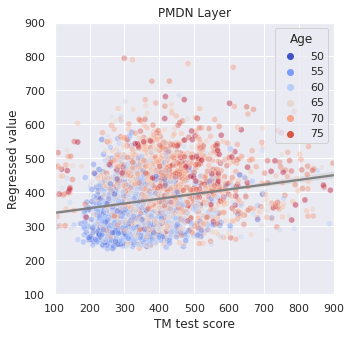

In [17]:
plt.figure(figsize=(5,5))
sns.regplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], scatter=False, color='gray')
sns.scatterplot(x=df_hold['hold_lbls'], y=df_hold['hold_preds'], hue=df_hold.c, palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.legend(title='Age')
plt.ylim(100,900)
plt.xlim(100,900)
plt.xlabel('TM test score')
plt.ylabel('Regressed value')
plt.title('PMDN Layer')
plt.savefig("TMTest-PMDNLayer.jpg", bbox_inches='tight')

In [15]:
#plot_graph(partialtest_hold, y_name='TM Test', yhat_name='prediction', c_name='Age', outfile_base='example')

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Plot of the c yhat correlation

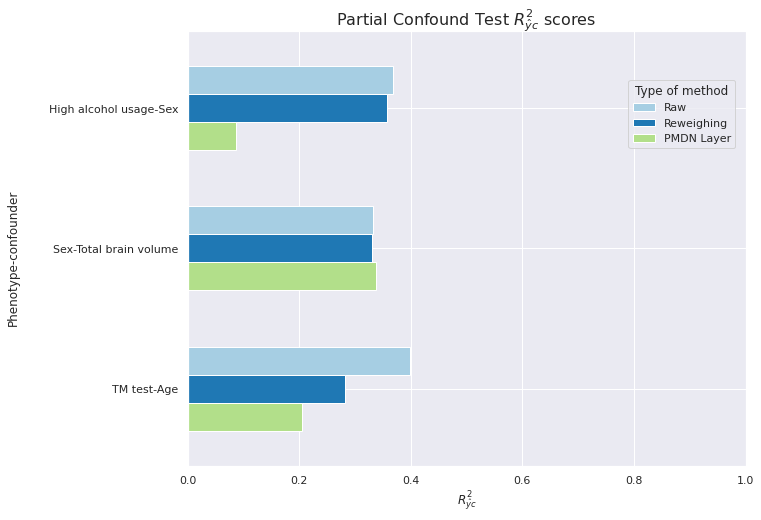

In [3]:
method_type=['Raw','Reweighing','PMDN Layer']
sex= [0.333,0.33,0.337]
highalc=[0.368,0.358,0.087]
tmtest=[0.399,0.282,0.205]

df=pd.DataFrame({
                'Sex-Total brain volume':sex,
                'High alcohol usage-Sex':highalc,
                'TM test-Age':tmtest}, index=method_type)

colors = plt.get_cmap('Paired').colors
ax = df.T.sort_index().plot.barh(figsize=(10,8), color=colors, width=0.6)
ax.invert_yaxis()
ax.set_title('Partial Confound Test $R^2_{ \^yc}$ scores', fontsize=16)
ax.set_xlabel("$R^2_{ \^yc}$", rotation=0)
ax.set_ylabel("Phenotype-confounder")
plt.xticks(rotation = 0)
ax.set_xlim([0, 1])
ax.yaxis.set_label_coords(-0.3, 0.48)

#plt.yticks(rotation = 15)
#ax.text(-0.005, 0.74, rf'--', transform=ax.transAxes, fontsize=16, verticalalignment='top')
#ax.text(-0.005, 0.52, rf'--', transform=ax.transAxes, fontsize=16, verticalalignment='top')
#ax.text(-0.005, 0.298, rf'--', transform=ax.transAxes, fontsize=16, verticalalignment='top')
plt.legend(bbox_to_anchor=(0.78, 0.9), loc="upper left", title='Type of method')
plt.savefig("Debiasedmethodcompared.jpg", bbox_inches='tight')

In [64]:
df

,Sex-Total brain volume,High alcohol usage-Sex,TM test-Age
Raw,0.333,0.368,0.399
Reweighing,1.000,0.358,0.282
PMDN Layer,0.337,0.087,0.205


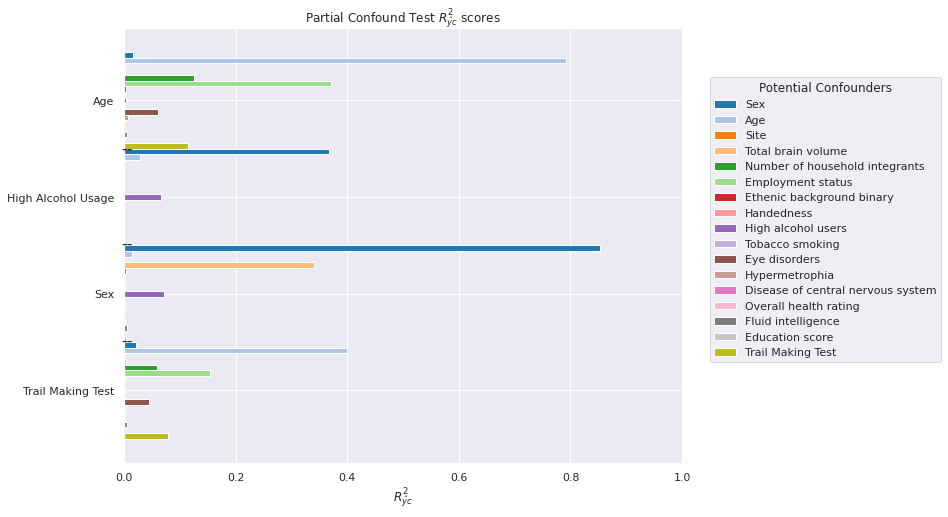

In [6]:
from matplotlib import cm

df=pd.read_csv('/ritter/share/projects/gonzalo/thesis/ML_for_alcohol_misuse/CNNpipeline/results/PlotResults/R2_values_biased.csv')
df.loc[df['Potential Confounder'] == 'Trail making average duration', 'Potential Confounder'] = 'Trail Making Test'
df.set_index('Potential Confounder',inplace=True)
colors = plt.get_cmap('tab20').colors
ax = df.T.sort_index().plot.barh(figsize=(10,8), color=colors, width=1)
ax.invert_yaxis()
ax.set_title('Partial Confound Test $R^2_{ \^yc}$ scores')
ax.set_xlabel("$R^2_{ \^yc}$")
ax.set_xlim([0, 1])

ax.text(-0.005, 0.74, rf'--', transform=ax.transAxes, fontsize=16, verticalalignment='top')
ax.text(-0.005, 0.52, rf'--', transform=ax.transAxes, fontsize=16, verticalalignment='top')
ax.text(-0.005, 0.298, rf'--', transform=ax.transAxes, fontsize=16, verticalalignment='top')
plt.legend(bbox_to_anchor=(1.04, 0.9), loc="upper left", title='Potential Confounders')
plt.savefig("R2scoresBiased.jpg", bbox_inches='tight')